In [1]:
from github import Github, ContentFile
from github.Repository import Repository
import zipfile
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

from typing import List

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio', 'Date'],
      dtype='object')


FIPS     Admin2  Province_State Country_Region          Last_Update  \
0  45001.0  Abbeville  South Carolina             US  2020-06-22 04:33:20   
1  22001.0     Acadia       Louisiana             US  2020-06-22 04:33:20   

         Lat      Long_  Confirmed  Deaths  Recovered  Active  \
0  34.223334 -82.461707       88.0     0.0        0.0    88.0   
1  30.295065 -92.414197      654.0    32.0        0.0   622.0   

                    Combined_Key  Incidence_Rate  Case-Fatality_Ratio  \
0  Abbeville, South Carolina, US      358.788274             0.000000   
1          Acadia, Louisiana, US     1054.073656             4.892966   

        Date  
0 2020-06-21  
1 2020-06-21

Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    3399
unique                    103
top       2020-06-14 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-06-21 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

     Incidence_Rate  Case-Fatality_Ratio       Date  
211             NaN                  NaN 2020-03-12  
212             NaN                  NaN 2020-03-1

Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                     103
unique                    103
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-06-21 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                     123
unique                    123
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-06-21 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

FIPS                Admin2         Province_State Country_Region  \
3440      NaN                   NaN              Recovered             US   
3440      NaN                   NaN              Recovered             US   
3436      NaN                   NaN              Recovered             US   
3435      NaN                   NaN              Recovered             US   
3434      NaN                   NaN              Recovered             US   
...       ...                   ...                    ...            ...   
3186      NaN                   NaN   Prince Edward Island         Canada   
3187      NaN                   NaN  Northwest Territories         Canada   
3188      NaN                   NaN       Diamond Princess         Canada   
3415  11001.0  District of Columbia   District of Columbia             US   
3416  53023.0       Garfield County             Washington             US   

              Last_Update        Lat       Long_  Confirmed  Deaths  \
3440  2020-06-22 04:33:20        NaN         NaN        0.0     0.0   
3440  2020-06-21 04:33:19        NaN         NaN        0.0     0.0   
3436  2020-06-20 04:33:19        NaN         NaN        0.0     0.0   
3435  2020-06-19 04:33:17        NaN         NaN        0.0     0.0   
3434  2020-06-18 04:33:18        NaN         NaN        0.0     0.0   
...                   ...        ...         ...        ...     ...   
3186        3/22/20 23:48  46.510700  -63.416800        3.0     0.0   
3187        3/22/20 23:48        NaN         NaN        1.0     0.0   
3188        3/22/20 23:48   0.000000    0.000000        0.0     1.0   
3415        3/22/20 23:45  38.904178  -77.016560      102.0     2.0   
3416        3/22/20 23:45  46.451975 -117.545403        1.0     2.0   

      Recovered    Active                                  Combined_Key  \
3440   622133.0 -696538.0                                 Recovered, US   
3440   617460.0 -691412.0                                 Recovered, US   
3436   606715.0 -679490.0                                 Recovered, US   
3435   599115.0 -673944.0                                 Recovered, US   
3434   592191.0 -663344.0                                 Recovered, US   
...         ...       ...                                           ...   
3186        0.0       0.0                  Prince Edward Island, Canada   
3187        0.0       0.0                 Northwest Territories, Canada   
3188        0.0       0.0                      Diamond Princess, Canada   
3415        0.0       0.0  District of Columbia,District of Columbia,US   
3416        0.0       0.0                 Garfield County,Washington,US   

      Incidence_Rate  Case-Fatality_Ratio       Date  
3440             NaN                  NaN 2020-06-21  
3440             NaN                  NaN 2020-06-20  
3436             NaN                  NaN 2020-06-19  
3435             NaN                  NaN 2020-06-18  
3434             NaN                  NaN 2020-06-17  
...              ...                  ...        ...  
3186             NaN                  NaN 2020-03-22  
3187             NaN                  NaN 2020-03-22  
3188             NaN                  NaN 2020-03-22  
3415             NaN                  NaN 2020-03-22  
3416             NaN                  NaN 2020-03-22  

[44126 rows x 15 columns]

In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20744 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            20744 non-null  float64
 1   Deaths               20744 non-null  float64
 2   Recovered            20744 non-null  float64
 3   Active               20744 non-null  float64
 4   Incidence_Rate       20744 non-null  float64
 5   Case-Fatality_Ratio  20744 non-null  float64
dtypes: float64(6)
memory usage: 1.0+ MB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0   
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   

                           Incidence_Rate  Case-Fatality_Ratio  
Country_Region Date                                             
 Azerbaijan    2020-02-28             0.0                  0.0  
Afghanistan    2020-02-24             0.0                  0.0  
               2020-02-25             0.0                  0.0  
               2020-02-26             0.0                  0.0  
               2020-02-27             0.0                  0.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'Brazil', 'Russia', 'India', 'United Kingdom', 'Peru', 'Spain',
       'Chile', 'Italy', 'Iran', 'France', 'Germany', 'Turkey', 'Pakistan',
       'Mexico', 'Saudi Arabia', 'Bangladesh', 'Canada', 'South Africa',
       'Qatar', 'China', 'Colombia', 'Belgium', 'Belarus', 'Sweden', 'Egypt',
       'Ecuador', 'Netherlands', 'Indonesia', 'United Arab Emirates',
       'Argentina', 'Singapore', 'Kuwait', 'Portugal', 'Ukraine', 'Poland',
       'Switzerland', 'Iraq', 'Philippines', 'Oman', 'Afghanistan',
       'Dominican Republic', 'Panama', 'Ireland', 'Bolivia', 'Romania',
       'Bahrain', 'Israel', 'Armenia', 'Nigeria'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Russia', 'Iran', 'Bolivia']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))
print()
print('\n'.join(c for c in population.index if 'Boli' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea

Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Venezuela (Bolivarian Republic of)


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South',
    'Bolivia (Plurinational State of)':'Bolivia'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6135 entries, ('Afghanistan', Timestamp('2020-02-24 00:00:00')) to ('United Kingdom', Timestamp('2020-06-21 00:00:00'))
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            6135 non-null   float64
 1   Deaths               6135 non-null   float64
 2   Recovered            6135 non-null   float64
 3   Active               6135 non-null   float64
 4   Incidence_Rate       6135 non-null   float64
 5   Case-Fatality_Ratio  6135 non-null   float64
 6   Confirmed_per_100k   6135 non-null   float64
 7   Deaths_per_100k      6135 non-null   float64
 8   Recovered_per_100k   6135 non-null   float64
 9   Active_per_100k      6135 non-null   float64
dtypes: float64(10)
memory usage: 506.4+ KB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   
               2020-02-28        1.0     0.0        0.0     1.0   

                           Incidence_Rate  Case-Fatality_Ratio  \
Country_Region Date                                              
Afghanistan    2020-02-24             0.0                  0.0   
               2020-02-25             0.0                  0.0   
               2020-02-26             0.0                  0.0   
               2020-02-27             0.0                  0.0   
               2020-02-28             0.0                  0.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Afghanistan    2020-02-24            0.002629              0.0   
               2020-02-25            0.002629              0.0   
               2020-02-26            0.002629              0.0   
               2020-02-27            0.002629              0.0   
               2020-02-28            0.002629              0.0   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Afghanistan    2020-02-24                 0.0         0.002629  
               2020-02-25                 0.0         0.002629  
               2020-02-26                 0.0         0.002629  
               2020-02-27                 0.0         0.002629  
               2020-02-28                 0.0         0.002629

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Afghanistan to United Kingdom
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Incidence_Rate           50 non-null     float64
 5   Case-Fatality_Ratio      50 non-null     float64
 6   Confirmed_per_100k       50 non-null     float64
 7   Deaths_per_100k          50 non-null     float64
 8   Recovered_per_100k       50 non-null     float64
 9   Active_per_100k          50 non-null     float64
 10  population               50 non-null     float64
 11  recovered_per_confirmed  50 non-null     float64
 12  deaths_per_confirmed     50 non-null     float64
dtypes: float64(13)
memory usage: 5.5+ KB


Confirmed    Deaths  Recovered     Active  \
Country_Region                                                    
Afghanistan             28833.0     581.0     8764.0    20311.0   
Argentina               42785.0    1011.0    12728.0    29046.0   
Armenia                 20268.0     350.0     9002.0    10917.0   
Bahrain                 21764.0      63.0    16419.0     5727.0   
Bangladesh             112306.0    1464.0    45077.0    70679.0   
Belarus                 58505.0     346.0    37666.0    25477.0   
Belgium                 60550.0    9696.0    16771.0    34083.0   
Bolivia                 24388.0     773.0     5454.0    18161.0   
Brazil                1085038.0   50617.0   600576.0   433845.0   
Canada                 103078.0    8482.0    65249.0    36033.0   
Chile                  242355.0    4479.0   200569.0    95631.0   
China                   84572.0    4639.0    79535.0    58046.0   
Colombia                68836.0    2353.0    27412.0    39071.0   
Dominican Republic      26677.0     662.0    15138.0    10877.0   
Ecuador                 50640.0    4223.0    24991.0    30088.0   
Egypt                   55233.0    2193.0    14736.0    38304.0   
France                 197008.0   29643.0    74496.0    98649.0   
Germany                191272.0    8895.0   174740.0    72864.0   
India                  425282.0   13699.0   237196.0   174387.0   
Indonesia               45891.0    2465.0    18404.0    25022.0   
Iran                   204952.0    9623.0   163591.0    34887.0   
Iraq                    30868.0    1100.0    13935.0    15833.0   
Ireland                 25379.0    1715.0    22698.0    14888.0   
Israel                  20778.0     306.0    15694.0     9808.0   
Italy                  238499.0   34634.0   182893.0   108257.0   
Kuwait                  39650.0     326.0    31240.0    15831.0   
Mexico                 180545.0   21825.0   134495.0    24225.0   
Netherlands             49801.0    6109.0      322.0    43506.0   
Nigeria                 20244.0     518.0     6879.0    12847.0   
Oman                    29471.0     131.0    15552.0    14923.0   
Pakistan               181088.0    3590.0    71458.0   106040.0   
Panama                  26030.0     501.0    14359.0    11170.0   
Peru                   251338.0    7861.0   143017.0   107469.0   
Philippines             30052.0    1169.0     7893.0    20990.0   
Poland                  31931.0    1356.0    16683.0    14494.0   
Portugal                39133.0    1530.0    25376.0    24065.0   
Qatar                   87369.0      98.0    68319.0    35634.0   
Romania                 24045.0    1512.0    16911.0     7716.0   
Russia                 583879.0    8101.0   339142.0   245382.0   
Saudi Arabia           157612.0    1267.0   101130.0    55215.0   
Singapore               42095.0      26.0    34942.0    20799.0   
South Africa            97302.0    1930.0    51608.0    43764.0   
Spain                  246272.0   28752.0   150376.0   105149.0   
Sweden                  56043.0    5053.0     4971.0    50990.0   
Switzerland             31292.0    1956.0    29000.0    14349.0   
Turkey                 187685.0    4950.0   160240.0    80808.0   
US                    2279569.0  119964.0   622133.0  1537472.0   
Ukraine                 37361.0    1012.0    17078.0    19271.0   
United Arab Emirates    44925.0     302.0    32415.0    17173.0   
United Kingdom         305803.0   42717.0     1319.0   261767.0   

                      Incidence_Rate  Case-Fatality_Ratio  Confirmed_per_100k  \
Country_Region                                                                  
Afghanistan             7.406686e+01             2.015052           75.793029   
Argentina               9.466592e+01             3.372463           95.543446   
Armenia                 6.839824e+02             1.726860          685.255710   
Bahrain                 1.279044e+03             0.289469         1326.131941   
Bangladesh              6.819262e+01             1.

In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

Confirmed    Deaths
Country_Region                           
US                    2279569.0  119964.0
Brazil                1085038.0   50617.0
Russia                 583879.0    8101.0
India                  425282.0   13699.0
United Kingdom         305803.0   42717.0
Peru                   251338.0    7861.0
Spain                  246272.0   28752.0
Chile                  242355.0    4479.0
Italy                  238499.0   34634.0
Iran                   204952.0    9623.0
France                 197008.0   29643.0
Germany                191272.0    8895.0
Turkey                 187685.0    4950.0
Pakistan               181088.0    3590.0
Mexico                 180545.0   21825.0
Saudi Arabia           157612.0    1267.0
Bangladesh             112306.0    1464.0
Canada                 103078.0    8482.0
South Africa            97302.0    1930.0
Qatar                   87369.0      98.0
China                   84572.0    4639.0
Colombia                68836.0    2353.0
Belgium                 60550.0    9696.0
Belarus                 58505.0     346.0
Sweden                  56043.0    5053.0
Egypt                   55233.0    2193.0
Ecuador                 50640.0    4223.0
Netherlands             49801.0    6109.0
Indonesia               45891.0    2465.0
United Arab Emirates    44925.0     302.0
Argentina               42785.0    1011.0
Singapore               42095.0      26.0
Kuwait                  39650.0     326.0
Portugal                39133.0    1530.0
Ukraine                 37361.0    1012.0
Poland                  31931.0    1356.0
Switzerland             31292.0    1956.0
Iraq                    30868.0    1100.0
Philippines             30052.0    1169.0
Oman                    29471.0     131.0
Afghanistan             28833.0     581.0
Dominican Republic      26677.0     662.0
Panama                  26030.0     501.0
Ireland                 25379.0    1715.0
Bolivia                 24388.0     773.0
Romania                 24045.0    1512.0
Bahrain                 21764.0      63.0
Israel                  20778.0     306.0
Armenia                 20268.0     350.0
Nigeria                 20244.0     518.0

In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

Confirmed_per_100k  Confirmed    Deaths
Country_Region                                               
Qatar                        3084.986217    87369.0      98.0
Bahrain                      1326.131941    21764.0      63.0
Chile                        1278.780880   242355.0    4479.0
Kuwait                        942.459575    39650.0     326.0
Peru                          773.098826   251338.0    7861.0
Singapore                     725.232813    42095.0      26.0
US                            692.741426  2279569.0  119964.0
Armenia                       685.255710    20268.0     350.0
Belarus                       618.942748    58505.0     346.0
Panama                        612.984053    26030.0     501.0
Oman                          592.382862    29471.0     131.0
Sweden                        558.397934    56043.0    5053.0
Spain                         526.934011   246272.0   28752.0
Belgium                       524.727354    60550.0    9696.0
Ireland                       519.795400    25379.0    1715.0
Brazil                        514.115363  1085038.0   50617.0
Saudi Arabia                  459.932202   157612.0    1267.0
United Arab Emirates          459.801243    44925.0     302.0
United Kingdom                452.839140   305803.0   42717.0
Russia                        400.267330   583879.0    8101.0
Italy                         393.887098   238499.0   34634.0
Portugal                      382.674739    39133.0    1530.0
Switzerland                   364.226343    31292.0    1956.0
France                        302.485512   197008.0   29643.0
Ecuador                       291.475767    50640.0    4223.0
Netherlands                   291.282925    49801.0    6109.0
Canada                        275.528308   103078.0    8482.0
Dominican Republic            248.413324    26677.0     662.0
Iran                          247.186560   204952.0    9623.0
Israel                        243.891188    20778.0     306.0
Germany                       229.021510   191272.0    8895.0
Turkey                        224.962105   187685.0    4950.0
Bolivia                       211.828228    24388.0     773.0
South Africa                  166.162704    97302.0    1930.0
Mexico                        141.520087   180545.0   21825.0
Colombia                      136.743666    68836.0    2353.0
Romania                       124.170146    24045.0    1512.0
Argentina                      95.543446    42785.0    1011.0
Ukraine                        84.923633    37361.0    1012.0
Poland                         84.277853    31931.0    1356.0
Pakistan                       83.618191   181088.0    3590.0
Iraq                           78.524970    30868.0    1100.0
Afghanistan                    75.793029    28833.0     581.0
Bangladesh                     68.879875   112306.0    1464.0
Egypt                          55.019483    55233.0    2193.0
India                          31.123864   425282.0   13699.0
Philippines                    27.795911    30052.0    1169.0
Indonesia                      16.957378    45891.0    2465.0
Nigeria                        10.073466    20244.0     518.0
China                           5.898519    84572.0    4639.0

In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

Confirmed    Deaths  deaths_per_confirmed
Country_Region                                                 
Belgium                 60550.0    9696.0              0.160132
France                 197008.0   29643.0              0.150466
Italy                  238499.0   34634.0              0.145217
United Kingdom         305803.0   42717.0              0.139688
Netherlands             49801.0    6109.0              0.122668
Mexico                 180545.0   21825.0              0.120884
Spain                  246272.0   28752.0              0.116749
Sweden                  56043.0    5053.0              0.090163
Ecuador                 50640.0    4223.0              0.083393
Canada                 103078.0    8482.0              0.082287
Ireland                 25379.0    1715.0              0.067576
Romania                 24045.0    1512.0              0.062882
Switzerland             31292.0    1956.0              0.062508
China                   84572.0    4639.0              0.054853
Indonesia               45891.0    2465.0              0.053714
US                    2279569.0  119964.0              0.052626
Iran                   204952.0    9623.0              0.046952
Brazil                1085038.0   50617.0              0.046650
Germany                191272.0    8895.0              0.046504
Poland                  31931.0    1356.0              0.042467
Egypt                   55233.0    2193.0              0.039705
Portugal                39133.0    1530.0              0.039097
Philippines             30052.0    1169.0              0.038899
Iraq                    30868.0    1100.0              0.035636
Colombia                68836.0    2353.0              0.034183
India                  425282.0   13699.0              0.032212
Bolivia                 24388.0     773.0              0.031696
Peru                   251338.0    7861.0              0.031277
Ukraine                 37361.0    1012.0              0.027087
Turkey                 187685.0    4950.0              0.026374
Nigeria                 20244.0     518.0              0.025588
Dominican Republic      26677.0     662.0              0.024815
Argentina               42785.0    1011.0              0.023630
Afghanistan             28833.0     581.0              0.020151
South Africa            97302.0    1930.0              0.019835
Pakistan               181088.0    3590.0              0.019825
Panama                  26030.0     501.0              0.019247
Chile                  242355.0    4479.0              0.018481
Armenia                 20268.0     350.0              0.017269
Israel                  20778.0     306.0              0.014727
Russia                 583879.0    8101.0              0.013874
Bangladesh             112306.0    1464.0              0.013036
Kuwait                  39650.0     326.0              0.008222
Saudi Arabia           157612.0    1267.0              0.008039
United Arab Emirates    44925.0     302.0              0.006722
Belarus                 58505.0     346.0              0.005914
Oman                    29471.0     131.0              0.004445
Bahrain                 21764.0      63.0              0.002895
Qatar                   87369.0      98.0              0.001122
Singapore               42095.0      26.0              0.000618

In [36]:
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate',
       'Case-Fatality_Ratio', 'Confirmed_per_100k', 'Deaths_per_100k',
       'Recovered_per_100k', 'Active_per_100k'],
      dtype='object')

In [37]:
covid.drop(columns=['Incidence_Rate','Case-Fatality_Ratio'], inplace=True)

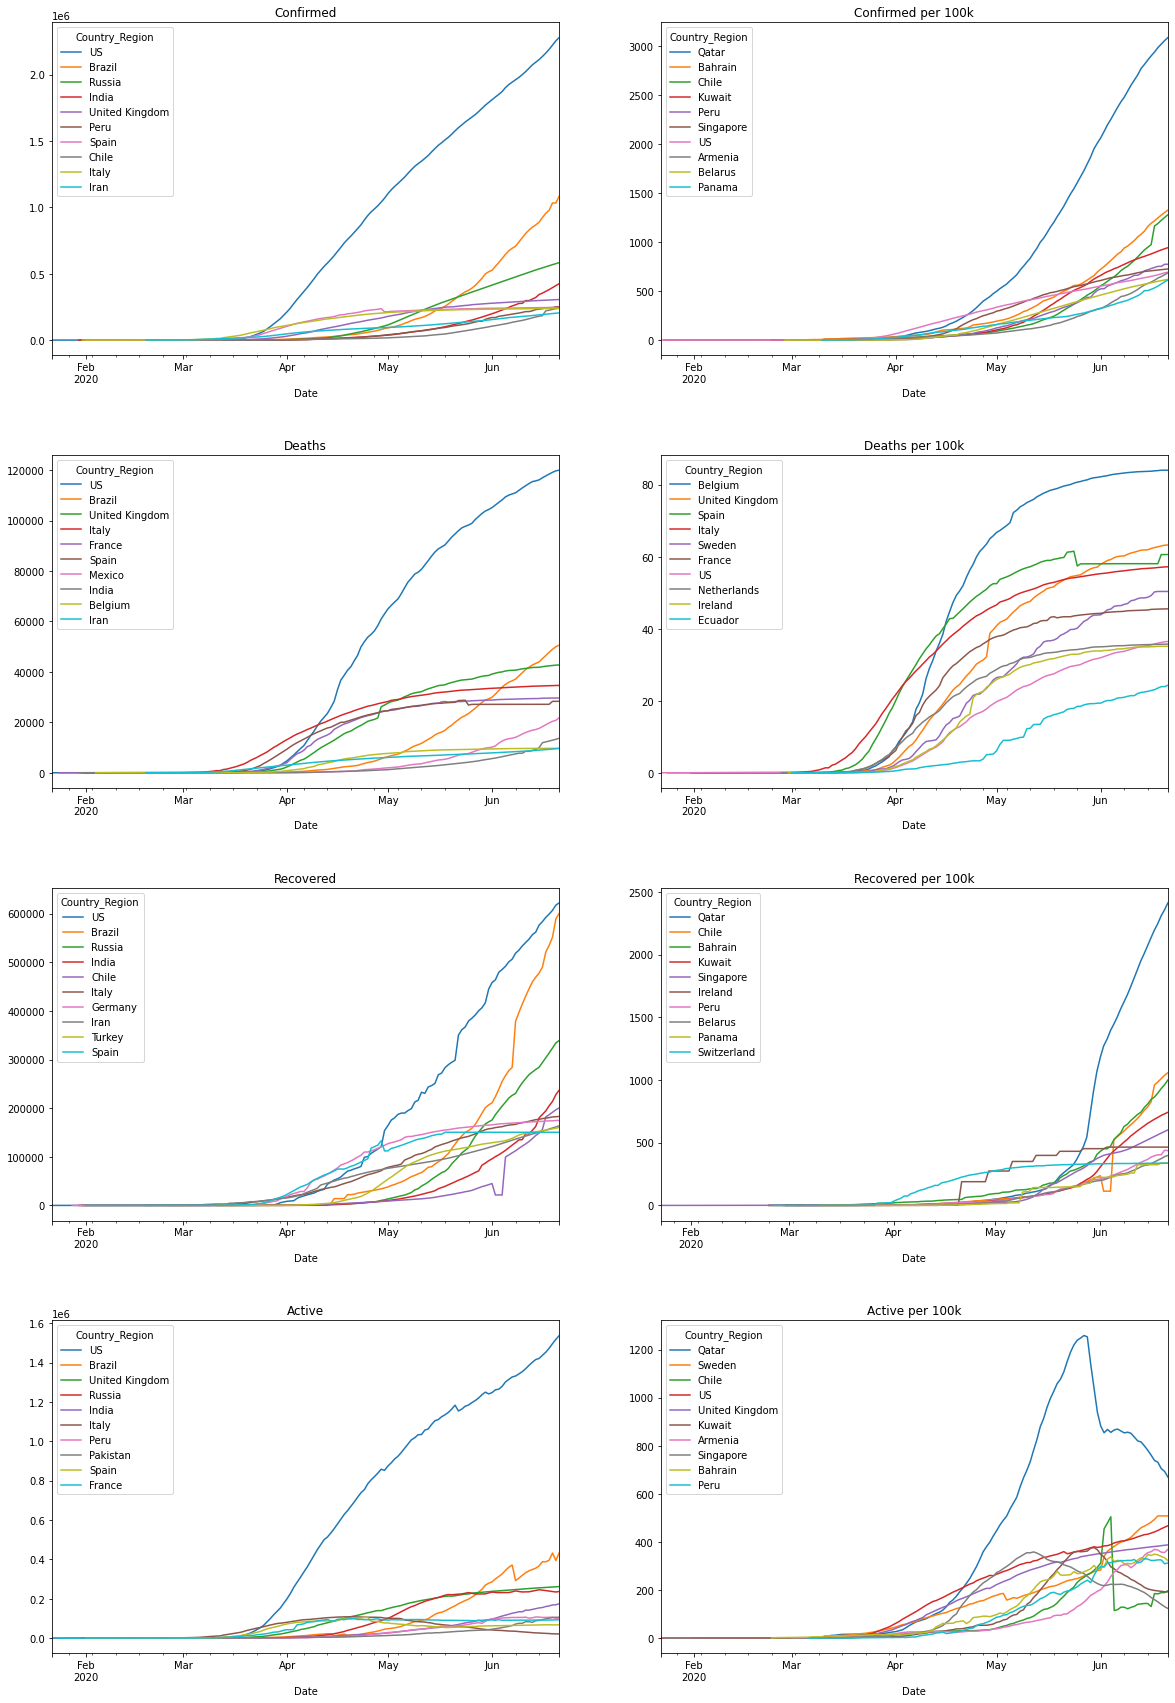

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

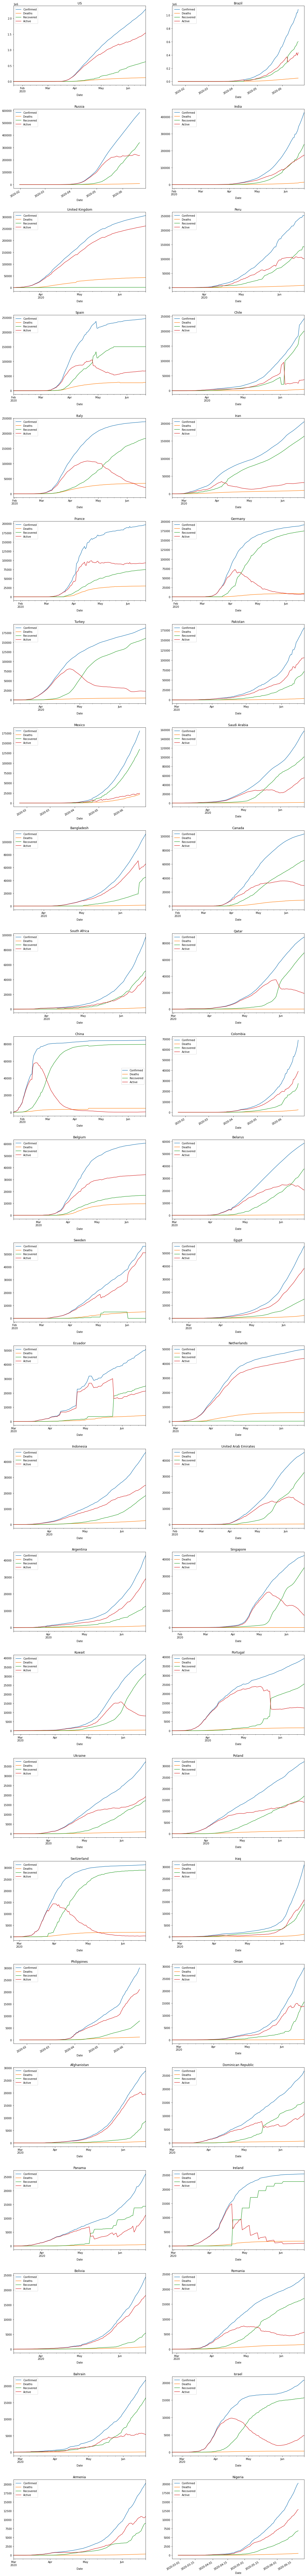

In [39]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [40]:
d=covid.groupby(level='Country_Region').rolling(window=10).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Afghanistan    Afghanistan    2020-02-24        NaN     NaN        NaN   
                              2020-02-25        NaN     NaN        NaN   
                              2020-02-26        NaN     NaN        NaN   
                              2020-02-27        NaN     NaN        NaN   
                              2020-02-28        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-06-17     1309.6   161.3        6.5   
                              2020-06-18     1310.1   169.3        5.8   
                              2020-06-19     1270.4   157.8        6.2   
                              2020-06-20     1299.2   146.1        5.0   
                              2020-06-21     1294.3   135.3        4.1   

                                          Active  Confirmed_per_100k  \
Country_Region Country_Region Date                                     
Afghanistan    Afghanistan    2020-02-24     NaN                 NaN   
                              2020-02-25     NaN                 NaN   
                              2020-02-26     NaN                 NaN   
                              2020-02-27     NaN                 NaN   
                              2020-02-28     NaN                 NaN   
...                                          ...                 ...   
United Kingdom United Kingdom 2020-06-17  1141.8            1.939282   
                              2020-06-18  1135.0            1.940022   
                              2020-06-19  1106.4            1.881233   
                              2020-06-20  1148.1            1.923881   
                              2020-06-21  1154.9            1.916625   

                                          Deaths_per_100k  Recovered_per_100k  \
Country_Region Country_Region Date                                              
Afghanistan    Afghanistan    2020-02-24              NaN                 NaN   
                              2020-02-25              NaN                 NaN   
                              2020-02-26              NaN                 NaN   
                              2020-02-27              NaN                 NaN   
                              2020-02-28              NaN                 NaN   
...                                                   ...                 ...   
United Kingdom United Kingdom 2020-06-17         0.238856            0.009625   
                              2020-06-18         0.250703            0.008589   
                              2020-06-19         0.233673            0.009181   
                              2020-06-20         0.216348            0.007404   
                              2020-06-21         0.200355            0.006071   

                                          Active_per_100k  
Country_Region Country_Region Date                         
Afghanistan    Afghanistan    2020-02-24              NaN  
                              2020-02-25              NaN  
                              2020-02-26              NaN  
                              2020-02-27              NaN  
                              2020-02-28              NaN  
...                                                   ...  
United Kingdom United Kingdom 2020-06-17         1.690800  
                              2020-06-18         1.680730  
                              2020-06-19         1.638379  
                              2020-06-20         1.700129  
                              2020-06-21         1.710199  

[6135 rows x 8 columns]

For some reason the 1st index level is duplicated

In [41]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Afghanistan    2020-02-24        NaN     NaN        NaN     NaN   
               2020-02-25        NaN     NaN        NaN     NaN   
               2020-02-26        NaN     NaN        NaN     NaN   
               2020-02-27        NaN     NaN        NaN     NaN   
               2020-02-28        NaN     NaN        NaN     NaN   
...                              ...     ...        ...     ...   
United Kingdom 2020-06-17     1309.6   161.3        6.5  1141.8   
               2020-06-18     1310.1   169.3        5.8  1135.0   
               2020-06-19     1270.4   157.8        6.2  1106.4   
               2020-06-20     1299.2   146.1        5.0  1148.1   
               2020-06-21     1294.3   135.3        4.1  1154.9   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Afghanistan    2020-02-24                 NaN              NaN   
               2020-02-25                 NaN              NaN   
               2020-02-26                 NaN              NaN   
               2020-02-27                 NaN              NaN   
               2020-02-28                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-06-17            1.939282         0.238856   
               2020-06-18            1.940022         0.250703   
               2020-06-19            1.881233         0.233673   
               2020-06-20            1.923881         0.216348   
               2020-06-21            1.916625         0.200355   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Afghanistan    2020-02-24                 NaN              NaN  
               2020-02-25                 NaN              NaN  
               2020-02-26                 NaN              NaN  
               2020-02-27                 NaN              NaN  
               2020-02-28                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-06-17            0.009625         1.690800  
               2020-06-18            0.008589         1.680730  
               2020-06-19            0.009181         1.638379  
               2020-06-20            0.007404         1.700129  
               2020-06-21            0.006071         1.710199  

[6135 rows x 8 columns]

Verify that the rolling values get reset at the country boundaries

In [42]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

119

In [43]:
d.iloc[len_of_first_group-10:len_of_first_group+20]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Afghanistan    2020-06-12      703.7    17.6      247.8   438.3   
               2020-06-13      683.5    15.7      267.9   399.9   
               2020-06-14      671.2    17.1      314.0   340.1   
               2020-06-15      655.8    16.9      340.2   298.7   
               2020-06-16      675.9    16.4      367.8   291.7   
               2020-06-17      653.2    14.7      428.3   210.2   
               2020-06-18      661.5    17.7      548.9    94.9   
               2020-06-19      641.9    16.4      531.1    94.4   
               2020-06-20      628.2    16.4      527.9    83.9   
               2020-06-21      594.3    15.5      543.8    35.0   
Argentina      2020-03-03        NaN     NaN        NaN     NaN   
               2020-03-04        NaN     NaN        NaN     NaN   
               2020-03-05        NaN     NaN        NaN     NaN   
               2020-03-06        NaN     NaN        NaN     NaN   
               2020-03-07        NaN     NaN        NaN     NaN   
               2020-03-08        NaN     NaN        NaN     NaN   
               2020-03-09        NaN     NaN        NaN     NaN   
               2020-03-10        NaN     NaN        NaN     NaN   
               2020-03-11        NaN     NaN        NaN     NaN   
               2020-03-12        NaN     NaN        NaN     NaN   
               2020-03-13        3.0     0.2        0.0     2.8   
               2020-03-14        3.3     0.2        0.1     3.0   
               2020-03-15        4.4     0.2        0.1     4.1   
               2020-03-16        5.4     0.2        0.1     5.1   
               2020-03-17        6.0     0.2        0.3     5.5   
               2020-03-18        6.7     0.1        0.3     6.3   
               2020-03-19        8.5     0.2        0.3     8.0   
               2020-03-20       11.1     0.2        0.3    10.6   
               2020-03-21       13.9     0.3        0.3    13.3   
               2020-03-22       24.7     0.3        2.7    21.7   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Afghanistan    2020-06-12            1.849809         0.046265   
               2020-06-13            1.796710         0.041270   
               2020-06-14            1.764377         0.044951   
               2020-06-15            1.723895         0.044425   
               2020-06-16            1.776732         0.043111   
               2020-06-17            1.717061         0.038642   
               2020-06-18            1.738879         0.046528   
               2020-06-19            1.687356         0.043111   
               2020-06-20            1.651343         0.043111   
               2020-06-21            1.562231         0.040745   
Argentina      2020-03-03                 NaN              NaN   
               2020-03-04                 NaN              NaN   
               2020-03-05                 NaN              NaN   
               2020-03-06                 NaN              NaN   
               2020-03-07                 NaN              NaN   
               2020-03-08                 NaN              NaN   
               2020-03-09                 NaN              NaN   
               2020-03-10                 NaN              NaN   
               2020-03-11                 NaN              NaN   
               2020-03-12                 NaN              NaN   
               2020-03-13            0.006699         0.000447   
               2020-03-14            0.007369         0.000447   
               2020-03-15            0.009826         0.000447   
               2020-03-16            0.012059         0.000447   
               2020-03-17            0.013399         0.000447   
               2020-03-18            0.014962         0.000223   
               2020-03-19         

In [44]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Afghanistan    2020-05-14     5639.0   136.0      691.0   4812.0   
               2020-05-15     6053.0   153.0      745.0   5155.0   
               2020-05-16     6402.0   168.0      745.0   5489.0   
               2020-05-17     6664.0   169.0      778.0   5717.0   
               2020-05-18     7072.0   173.0      801.0   6098.0   
               2020-05-19     7653.0   178.0      850.0   6625.0   
               2020-05-20     8145.0   187.0      930.0   7028.0   
               2020-05-21     8676.0   193.0      938.0   7545.0   
               2020-05-22     9216.0   205.0      996.0   8015.0   
               2020-05-23     9998.0   216.0     1040.0   8742.0   
               2020-05-24    10582.0   218.0     1075.0   9289.0   
               2020-05-25    11173.0   219.0     1097.0   9857.0   
               2020-05-26    11831.0   220.0     1128.0  10483.0   
               2020-05-27    12456.0   227.0     1138.0  11091.0   
               2020-05-28    13036.0   235.0     1209.0  11592.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Afghanistan    2020-05-14           14.823185         0.357502   
               2020-05-15           15.911463         0.402190   
               2020-05-16           16.828876         0.441620   
               2020-05-17           17.517593         0.444249   
               2020-05-18           18.590098         0.454763   
               2020-05-19           20.117367         0.467907   
               2020-05-20           21.410683         0.491565   
               2020-05-21           22.806518         0.507337   
               2020-05-22           24.226010         0.538882   
               2020-05-23           26.281646         0.567797   
               2020-05-24           27.816801         0.573054   
               2020-05-25           29.370357         0.575683   
               2020-05-26           31.100036         0.578312   
               2020-05-27           32.742967         0.596713   
               2020-05-28           34.267608         0.617742   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Afghanistan    2020-05-14            1.816425        12.649258   
               2020-05-15            1.958374        13.550899   
               2020-05-16            1.958374        14.428881   
               2020-05-17            2.045121        15.028223   
               2020-05-18            2.105581        16.029754   
               2020-05-19            2.234387        17.415074   
               2020-05-20            2.444682        18.474436   
               2020-05-21            2.465712        19.833469   
               2020-05-22            2.618176        21.068953   
               2020-05-23            2.733838        22.980011   
               2020-05-24            2.825842        24.417905   
               2020-05-25            2.883673        25.911001   
               2020-05-26            2.965163        27.556561   
               2020-05-27            2.991450        29.154805   
               2020-05-28            3.178087        30.471779   

                           Confirmed_diff  Deaths_diff  Recovered_diff  \
Country_Region Date                                                      
Afghanistan    2020-05-14           274.5          4.6            29.4   
               2020-05-15           282.9          5.8            32.4   
               2020-05-16           301.0          6.4            28.7   
               2020-05-17           310.1          6.3            31.0   
               2020-05-18           329.4          6.4            32.9   
               2020-05-19           362.0          6.3            34.8   
               2020-05-20       

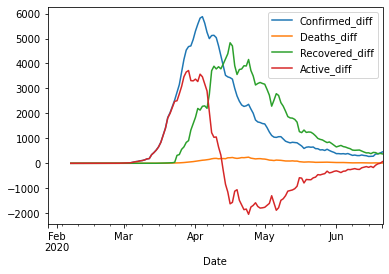

In [45]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

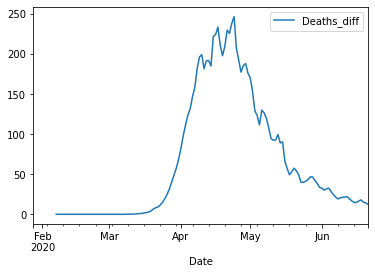

In [46]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [47]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

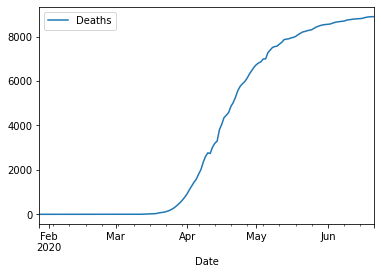

In [48]:
covid.loc[('Germany',),['Deaths']].plot()

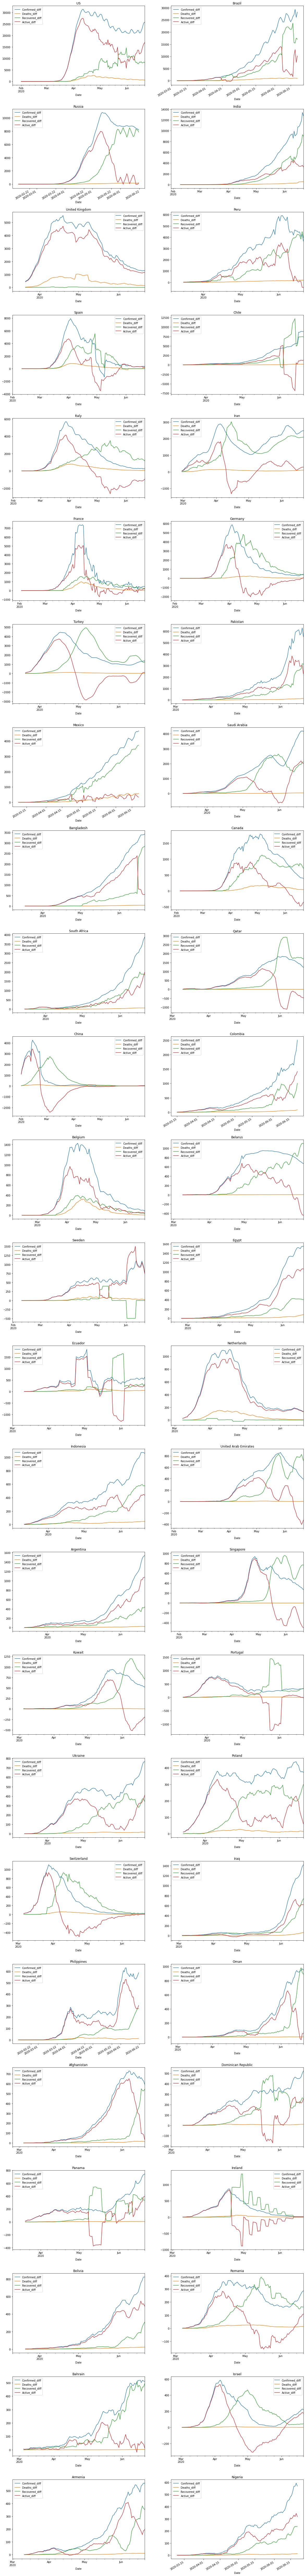

In [49]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country,['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot(ax=ax, title=country)

fig.subplots_adjust(hspace=0.3)